# Lesson 1

## Is it an apple?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [16]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

The below codes are created by referring to the **fastai** course "Practical Deep Learning for Coders" "Part 1" "1: Getting started" Kaggle notebook "Is it a bird? Creating a model from your own data".  

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "apple photos"
1. Use DuckDuckGo to search for images of "pear photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of apples and pears

In [17]:
from fastcore.all import *
import time
import json

def search_images(term, max_images=200):
    """
    Create a function to download images by using Duckduckgo searching the term and the maximum number of images downloaded is 200
    """
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')    
    headers = dict( referer='https://duckduckgo.com/' )
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Let's start by searching for an apple photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [26]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('apple photos', max_images=5)
urls[1]

'https://images.pexels.com/photos/39803/pexels-photo-39803.jpeg?cs=srgb&dl=apple-food-fruit-39803.jpg&fm=jpg'

You probably need to download a few images to give it a try.

...and then download a URL and take a look at it:

Download apple images.

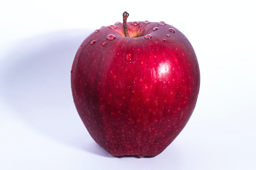

In [27]:
from fastdownload import download_url
dest = 'apple.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Similarly, download pear images.

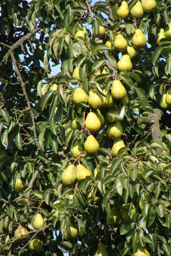

In [30]:
# you may also need to try a few urls to have a correct url to open the image
download_url(search_images('pear photos', max_images=5)[2], 'pear.jpg', show_progress=False)
Image.open('pear.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "pear" and "apple" photos, and save each group of photos to a different folder:

In [36]:
# download pear and apple images
searches = 'pear','apple'
path = Path('apple_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:1018: UserWarning: Couldn't allocate palette entry f

In [39]:
# !ls apple_or_not/pear

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [40]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

45

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

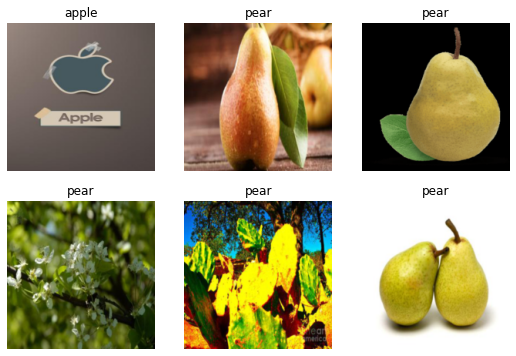

In [41]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

We can also see some of our apple images are related to the product Apple logo.

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [42]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
# learn.data.classes
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.737716,0.368527,0.120275,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.507605,0.237253,0.085911,00:04
1,0.326642,0.246615,0.089347,00:04
2,0.197392,0.267047,0.072165,00:04
3,0.128714,0.323000,0.085911,00:04
4,0.096340,0.235839,0.072165,00:04
5,0.076035,0.271193,0.082474,00:04
6,0.044790,0.290032,0.065292,00:04
7,0.034311,0.226904,0.072165,00:04
8,0.021789,0.233739,0.079038,00:04
9,0.015269,0.232252,0.072165,00:04


We can see that our model is a little overfitting.

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that apple we downloaded at the start:

In [43]:
result,pred_class,probs = learn.predict(PILImage.create('apple.jpg'))
print(f"Probability it's a {result}: {probs[pred_class]:.4f}")

Probability it's a apple: 1.0000


Similarly, let's try the pear image.

In [44]:
result,pred_class,probs = learn.predict(PILImage.create('pear.jpg'))
print(f"Probability it's a {result}: {probs[pred_class]:.4f}")

Probability it's a pear: 1.0000
